In [16]:
import numpy as np
import pickle
from collections import defaultdict

hopper_data = defaultdict(dict)
for k in [1, 2, 5, 10, 20]:
    for s in range(5):
        with open('s%d_k%d_stats.pkl' % (s, k), 'rb') as f:
            hopper_data[k][s] = pickle.load(f)
            
data_keys = list(hopper_data[2][0].keys())
print(data_keys)

from pprint import pprint
pprint(hopper_data[2][0]['program_args'])

['loss_y_by_head', 'evalrew_head_idx', 'evalrew_x', 'evalrew_y', 'ev_before_y', 'rew_x_by_head', 'rew_y_by_head', 'ev_after_y', 'kl_y_by_head', 'program_args', 'iter_x']
{'animate': False,
 'desired_kl': 0.005,
 'eval_every': 10,
 'eval_timesteps': 10000,
 'gamma': 0.99,
 'gym_env': 'Hopper-v1',
 'logdir': '/home/ubuntu/exp1-deeprl-proj/log',
 'min_timesteps_per_batch': 25000,
 'n_iter': 300,
 'num_heads': 2,
 'seed': 0,
 'vf_params': {'n_epochs': 25},
 'vf_type': 'nn'}


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_unpickled_data(data, bootstrap_heads, skip=[], avgpast=100):
    fig, axes = plt.subplots(5, 1, figsize=(7, 8))
    evalrew_ax, rew_ax, loss_ax, kl_ax, ev_ax = axes
    plt.tight_layout(pad=2.0, h_pad=1.5)

    
    rew_ax.set_title('Average Reward (Rollout Head)')
    rew_x_by_head = data['rew_x_by_head']
    rew_y_by_head = data['rew_y_by_head']
    for i in range(bootstrap_heads):
        rew_x, rew_y = rew_x_by_head[i], rew_y_by_head[i]
        rew_ax.plot(rew_x, rew_y, marker='.')
        
    evalrew_ax.set_title('Evaluation Reward (Best Head)')
    evalrew_x = data['evalrew_x']
    evalrew_y = data['evalrew_y']
    evalrew_ax.plot(evalrew_x, evalrew_y, marker='.')
            

    iter_x = data['iter_x']
    
    if 'loss' in skip:
        loss_ax.remove()
    else:
        loss_ax.set_title('Loss (After train iteration, by head)')
        loss_y_by_head = data['loss_y_by_head']
        for i in range(bootstrap_heads):
            loss_y = loss_y_by_head[i]
            loss_ax.plot(iter_x, loss_y)

    kl_ax.set_title('KL')
    kl_y_by_head = data['kl_y_by_head']
    for i in range(bootstrap_heads):
        kl_y = kl_y_by_head[i]
        kl_ax.plot(iter_x, kl_y) 

    ev_ax.set_title('Explained Variance (After update, by head)')
    ev_ax.set_ylim(-1, 1)
    ev_before_y = data['ev_before_y']
    ev_after_y = data['ev_after_y']
    ev_ax.plot(iter_x, ev_before_y)
    ev_ax.plot(iter_x, ev_after_y)

In [18]:
def smooth_ts(ts, nback=100):
    smoothed = np.empty(len(ts) - nback)
    for i, t in enumerate(range(nback, len(ts))):
        smoothed[i] = np.mean(ts[t-nback:t])
    return smoothed

In [37]:
import pandas as pd

dataframe_data = []
for k, by_seed in sorted(hopper_data.items()):
    for s, data in by_seed.items():
        for x, y in zip(data['evalrew_x'], data['evalrew_y']):
            dataframe_data.append((x, y, s, k))

cols = ['time', 'value', 'unit', 'condition']
names = ['Episode', 'Evaluation Reward', 'unit', 'Num Heads']
hopper_evalrew_df = pd.DataFrame(dataframe_data, columns=names)

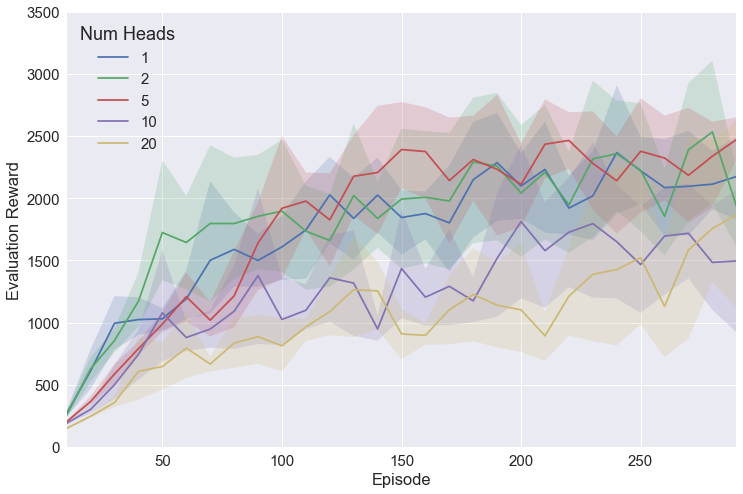

In [40]:
whyseabornwhy = dict(zip(cols, names))
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.plotting_context('notebook', font_scale=1.5).__enter__()
ax = sns.tsplot(hopper_evalrew_df, ci=[95], ax=ax, **whyseabornwhy)
ax.set_ylim(0, 3500)
plt.show()

In [101]:
import pandas as pd

AVG_NBACK = 5

dataframe_data = []
for k, by_seed in sorted(hopper_data.items()):
    for s, data in by_seed.items():
        
        xdata, ydata = data['evalrew_x'], data['evalrew_y']
        
        avg_ydata = np.empty(len(ydata) - AVG_NBACK)
        for i, t in enumerate(range(AVG_NBACK, len(ydata))):
            avg_ydata[i] = np.mean(ydata[t-AVG_NBACK:t])
        avg_xdata = xdata[AVG_NBACK:]
        
        for x, y in zip(avg_xdata, avg_ydata):
            dataframe_data.append((x, y, s, k))

cols = ['time', 'value', 'unit', 'condition']
rew_names = ['Episode', 'Evaluation Reward\nAvg of 50 Episodes', 'unit', 'Num Heads']
hopper_evalrew_df = pd.DataFrame(dataframe_data, columns=rew_names)

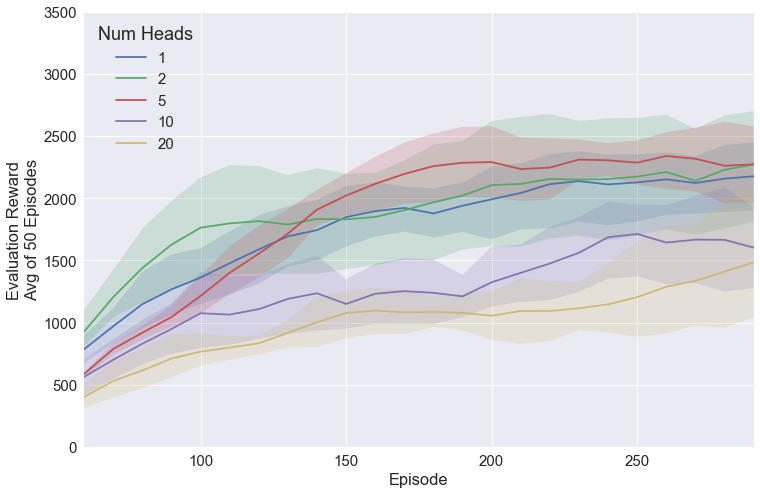

In [102]:
rew_whyseabornwhy = dict(zip(cols, rew_names))
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.plotting_context('notebook', font_scale=1.5).__enter__()
ax = sns.tsplot(hopper_evalrew_df, ci=[95], ax=ax, **rew_whyseabornwhy)
ax.set_ylim(0, 3500)
ax.legend(title='Num Heads', loc='upper left')
plt.show()

In [103]:
import pandas as pd
from scipy.interpolate import spline

AVG_LEN = 50
SPLINE_POINTS = 250

dataframe_data = []
for k, by_seed in sorted(hopper_data.items()):
    for s, data in by_seed.items():
        ev_x, ev_y = data['iter_x'], data['ev_before_y']
        
        avg_ev_y = np.empty(len(ev_y) - AVG_LEN)
        for i, t in enumerate(range(AVG_LEN, len(ev_y))):
            avg_ev_y[i] = np.mean(ev_y[t-AVG_LEN:t])
        avg_x = ev_x[AVG_LEN:]
        
        spline_x = np.linspace(min(avg_x), max(avg_x), SPLINE_POINTS)
        spline_ev_y = spline(avg_x, avg_ev_y, spline_x)
        
        for x, y in zip(spline_x, spline_ev_y):
            dataframe_data.append((x, y, s, k))

cols = ['time', 'value', 'unit', 'condition']
names = ['Episode', 'Explained Variance (Before Update)\nAvg of 50 Episodes', 'unit', 'Num Heads']
hopper_ev_df = pd.DataFrame(dataframe_data, 
                            columns=names)

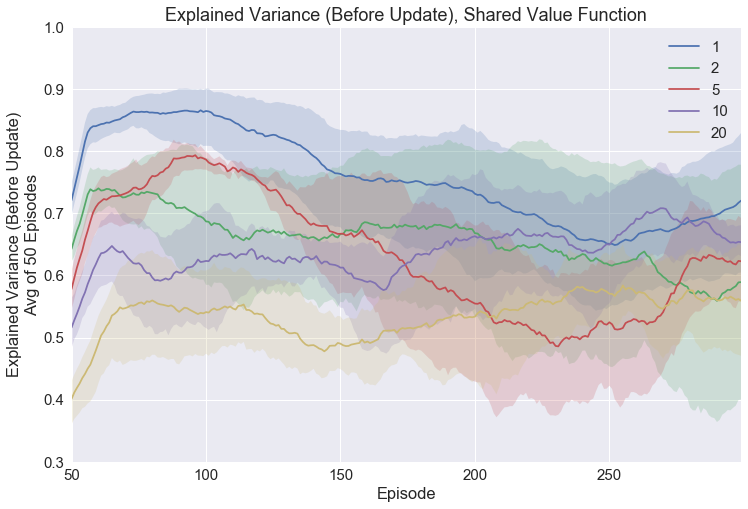

In [104]:
whyseabornwhy = dict(zip(cols, names))
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax = sns.tsplot(hopper_ev_df, ci=[95], ax=ax, **whyseabornwhy)
ax.set_ylim(0.3, 1)
ax.set_title('Explained Variance (Before Update), Shared Value Function')
ax.legend(loc='best')
plt.show()

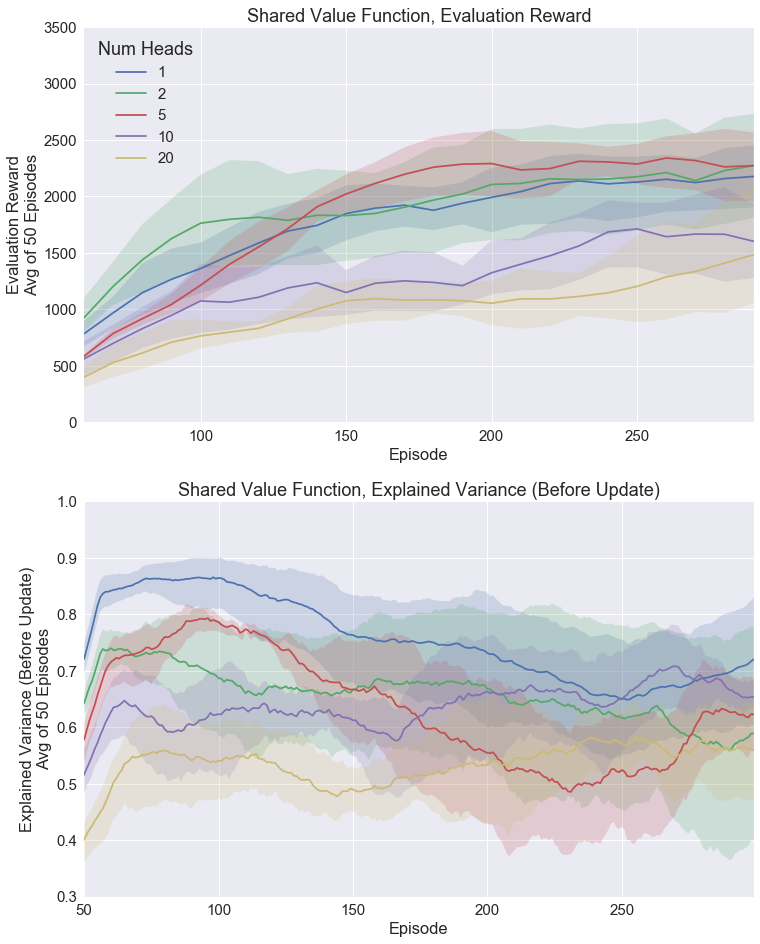

In [109]:
fig, axs = plt.subplots(2, 1, figsize=(12, 16))
rew_ax, ev_ax = axs

sns.plotting_context('notebook', font_scale=1.5).__enter__()
ax = sns.tsplot(hopper_evalrew_df, ci=[95], ax=rew_ax, **rew_whyseabornwhy)
ax.set_ylim(0, 3500)
ax.set_title('Shared Value Function, Evaluation Reward')
ax.legend(title='Num Heads', loc='upper left')

ax = sns.tsplot(hopper_ev_df, ci=[95], ax=ev_ax, **whyseabornwhy)
ax.set_ylim(0.3, 1)
ax.set_title('Shared Value Function, Explained Variance (Before Update)')
ax.legend_.remove()
plt.show()